In [1]:
#pip install pydiffmap

In [2]:
from scipy.io import loadmat
from pprint import pprint
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
import torch
from tqdm import tqdm
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import pickle
from mpl_toolkits.mplot3d import Axes3D
import copy

from pydiffmap import diffusion_map as dm
from sklearn.metrics.pairwise import euclidean_distances

## Functions 

In [3]:
def create_cumul_var_graph(pca):
    ratio = pca.explained_variance_ratio_
    cumulative = np.cumsum(ratio)
    n_components = np.arange(0, len(cumulative))
    plt.plot(n_components, cumulative)
    plt.title("Cumulative Explained Variance by number of components")
    plt.ylabel("Cumulative Ratio")
    plt.xlabel("Number of components")
    

def create_3D_graph(data_3D, classes, ids, fat_pct, filename):
    fig = plt.figure(figsize=(5,15))
    
    #normal vs fatty
    normal = data_3D[classes == 0]
    fatty = data_3D[classes == 1]
    ax1 = fig.add_subplot(311, projection='3d')
    ax1.scatter(normal[:,2], normal[:,1], normal[:,0])
    ax1.scatter(fatty[:,2], fatty[:,1], fatty[:,0])
    ax1.title.set_text("Non Fatty vs Fatty Liver")
    
    #Fat %
    ax2 = fig.add_subplot(312, projection="3d")
    ax2.scatter(data_3D[:,2], data_3D[:,1], data_3D[:,0], c = fat_pct)
    ax2.title.set_text("Coloration by Fat %")
    
    #patient variance
    ax3 = fig.add_subplot(313, projection='3d')
    for i in range(5):
        data_i = data_3D[ids == i]
        ax3.scatter(data_i[:,0], data_i[:,1], data_i[:,2])
        data_i3 = data_3D[ids == i+30]
        ax3.scatter(data_i3[:,0], data_i3[:,1], data_i3[:,2])
    
    ax3.title.set_text("Patients Variance")
    
    plt.savefig(filename + ".png")
        
    return fig

def save_simple_2D_graph(data_2D, classes, ids, filename):
    normal = data_2D[classes == 0]
    fatty = data_2D[classes == 1]
    plt.scatter(normal[:,0], normal[:,1])
    plt.scatter(fatty[:,0], fatty[:,1])
    plt.title("Non Fatty vs Fatty Liver")
    plt.savefig(filename + ".png")

def create_2D_graph(data_2D, classes, ids, fat_pct, filename):
    fig = plt.figure(figsize=(5,15))
    #normal vs fatty
    normal = data_2D[classes == 0]
    fatty = data_2D[classes == 1]
    ax1 = fig.add_subplot(311)
    ax1.scatter(normal[:,0], normal[:,1])
    ax1.scatter(fatty[:,0], fatty[:,1])
    ax1.title.set_text("Non Fatty vs Fatty Liver")
    
    #Fat %
    ax2 = fig.add_subplot(312)
    scatter2 = ax2.scatter(data_2D[:,0], data_2D[:,1], c = fat_pct)
    ax2.title.set_text("Coloration by Fat %")
    plt.colorbar(scatter2,ax=ax2)
    
    #patient variance
    ax3 = fig.add_subplot(313)
    for i in range(5):
        data_i = data_2D[ids == i]
        ax3.scatter(data_i[:,0], data_i[:,1])
        
        data_i3 = data_2D[ids == i+30]
        ax3.scatter(data_i3[:,0], data_i3[:,1])
        
    ax3.title.set_text("Patients Variance")
    
    plt.savefig(filename + ".png")
        
    return fig

# 1. Visualization of Raw US images (No transformation)

## Import Data

In [4]:
with open('../data/02_interim/bmodes_steatosis_assessment_IJCARS.pickle', 'rb') as handle:
    df = pickle.load(handle)
    
M, N= 434, 636 # ultrasound image dimension

# Reshape the data appropriately
data = df['img'].iloc[0].view(1,M*N)
for i in tqdm(range(1,len(df['img']))):
    data = torch.cat([data,df['img'].iloc[i].view(1,M*N)])

100%|████████████████████████████████████████| 549/549 [01:54<00:00,  4.79it/s]


In [5]:
neighbor_params = {'n_jobs': -1, 'algorithm': 'ball_tree'}
dist = euclidean_distances(data, data)
eps = np.percentile(dist[dist>0]**2, 0.75)
mydmap = dm.DiffusionMap.from_sklearn(n_evecs=3, k=200, epsilon=eps, alpha=0.5, neighbor_params=neighbor_params)
dmap = mydmap.fit_transform(data)

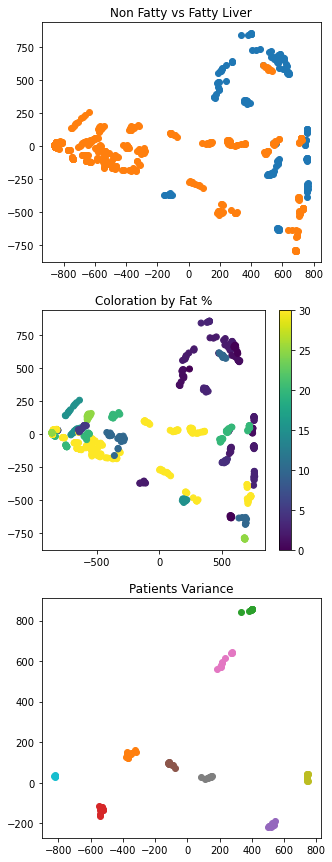

In [6]:
fat_lvl = copy.deepcopy(df['fat'])
fat_lvl[fat_lvl >30] = 30

fig_2d = create_2D_graph(dmap, df['class'], df['id'], fat_lvl, "DM2D-base")

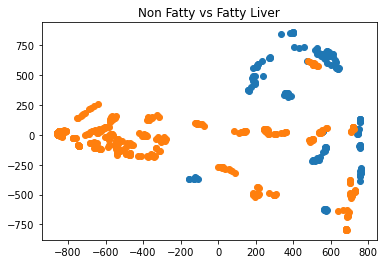

In [7]:
save_simple_2D_graph(dmap, df['class'], df['id'], "DM-base")

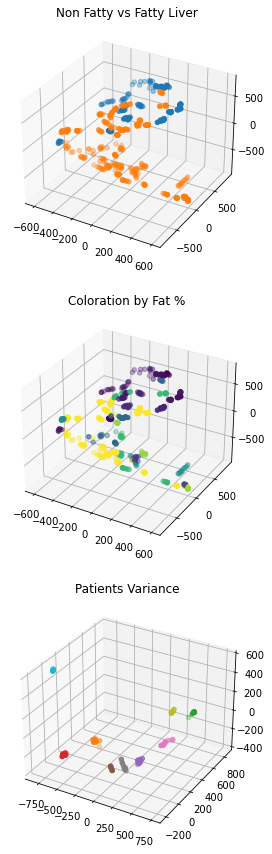

In [8]:
fig_3D = create_3D_graph(dmap, df['class'], df['id'], fat_lvl, "DM3D-base")

# 2. Scattering Features

In [9]:
with open('../data/03_features/scattering_features_J_3.pickle', 'rb') as handle:
    scatter_dict = pickle.load(handle)
    df_scattering = scatter_dict['df']
    scattering_params = {'J':scatter_dict['J'],
                     'M':scatter_dict['M'],
                     'N':scatter_dict['N']}
#Transforming df_scattering to a numpy array excluding class and id
df_scattering.drop("class", inplace = True, axis=1)
df_scattering.drop("id", inplace=True, axis=1)
df_scattering = df_scattering.to_numpy()


In [10]:
dist = euclidean_distances(df_scattering, df_scattering)
eps = np.percentile(dist[dist>0]**2, 2)

In [11]:
neighbor_params = {'n_jobs': -1, 'algorithm': 'ball_tree'}
mydmap = dm.DiffusionMap.from_sklearn(n_evecs=3, k=200, epsilon=eps, alpha=0.5, neighbor_params=neighbor_params)
dmap_s = mydmap.fit_transform(df_scattering)

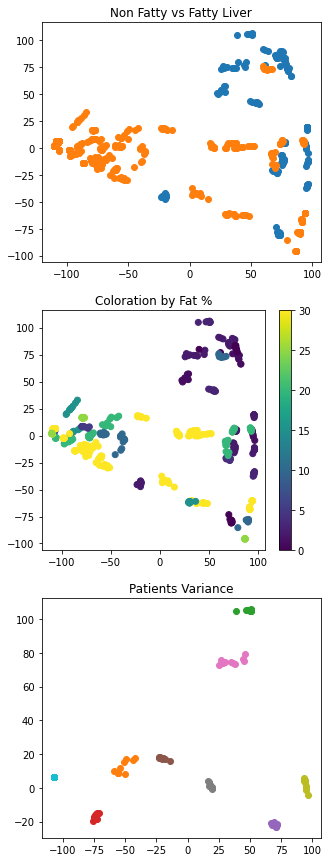

In [12]:
fig_2d = create_2D_graph(dmap_s, df['class'], df['id'], fat_lvl, "DM2D-scattering")

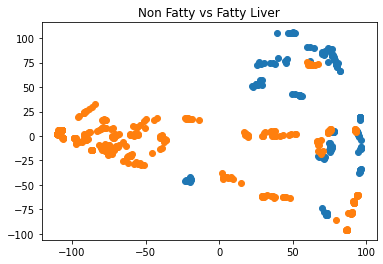

In [13]:
save_simple_2D_graph(dmap_s, df['class'], df['id'], "DM-scattering")

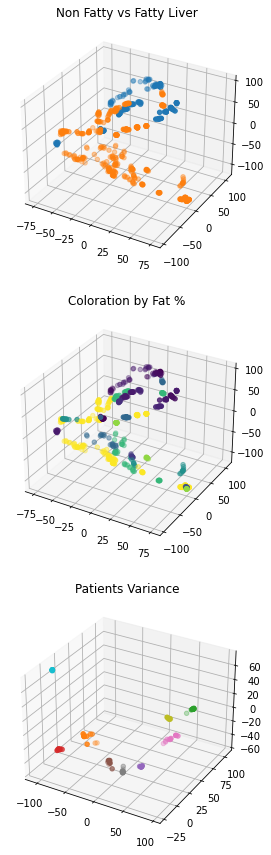

In [14]:
fig_3D = create_3D_graph(dmap_s, df['class'], df['id'], fat_lvl, "DM3D-scattering")

# 3. Deep Features

In [15]:
#with open('../data/03_features/inception_dict_tensor_avg_pooling.pickle', 'rb') as handle:
with open('../data/03_features/coco.pickle', 'rb') as handle:
    dict_deep_features = pickle.load(handle)
    deep_features = dict_deep_features['features']
    label = dict_deep_features['label']
    pid = dict_deep_features['pid']

label = label.to_numpy(dtype=int)

In [16]:
neighbor_params = {'n_jobs': -1, 'algorithm': 'ball_tree'}
mydmap = dm.DiffusionMap.from_sklearn(n_evecs=3, k=200, epsilon='bgh', alpha=0.5, neighbor_params=neighbor_params)
dmap_DL = mydmap.fit_transform(deep_features)

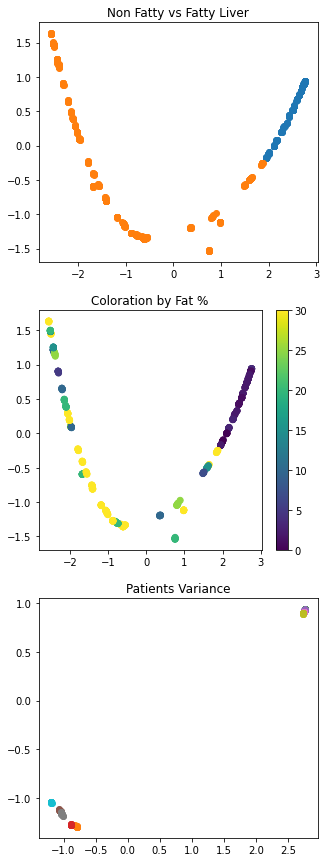

In [17]:
fig_2d = create_2D_graph(dmap_DL, label, df['id'], fat_lvl, "DM2D-DL")

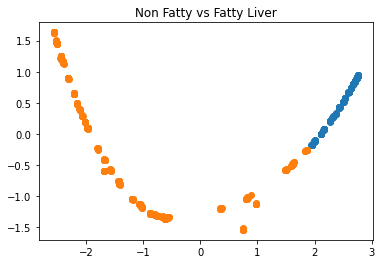

In [18]:
save_simple_2D_graph(dmap_DL, df['class'], df['id'], "DM-DL")

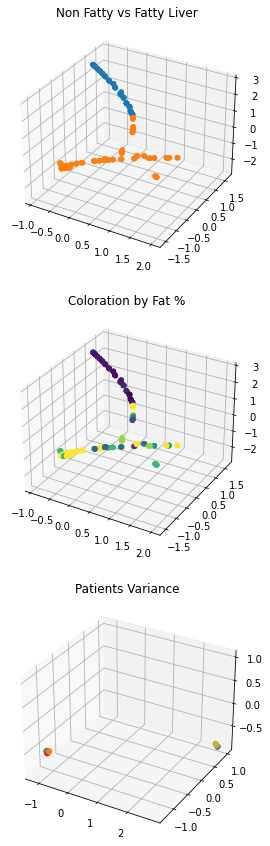

In [19]:
fig_3D = create_3D_graph(dmap_DL, df['class'], df['id'], fat_lvl, "DM3D-DL")